In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv("/content/sample_data/Smart Home Dataset.csv", low_memory=False)
data = data.dropna()

In [3]:
data["timestamp"] = pd.to_numeric(data["time"], errors="coerce")
data["date_time"] = pd.to_datetime(data["timestamp"], unit="s")
data["hour_of_day"] = data["date_time"].dt.hour

In [4]:
weather_feats = [
    "temperature", "humidity", "visibility", "windSpeed",
    "pressure", "cloudCover", "windBearing",
    "dewPoint", "precipProbability"
]

for w in weather_feats:
    data[w] = pd.to_numeric(data[w], errors="coerce")

In [5]:
encoder = LabelEncoder()
data["weather_label"] = encoder.fit_transform(data["summary"].astype(str))


=== BASELINE PIVOT TABLOLARI ===

Saat Bazlı Normal Tüketim (hour_baseline):
             hour_baseline_kw
hour_of_day                  
0                    0.833997
1                    0.688069
2                    1.071602
3                    0.848788
4                    0.923741
5                    0.978229
6                    0.961058
7                    0.885736
8                    0.810143
9                    0.812542
10                   0.872873
11                   0.911499
12                   1.079477
13                   0.868848
14                   0.899126
15                   0.881205
16                   0.865224
17                   0.817175
18                   0.937585
19                   0.794549
20                   0.959575
21                   0.983345
22                   0.939333
23                   0.827356

Sıcaklığa Göre Normal Tüketim (temp_baseline):
             temp_baseline_kw
temperature                  
-12.64               1.149906
-12.

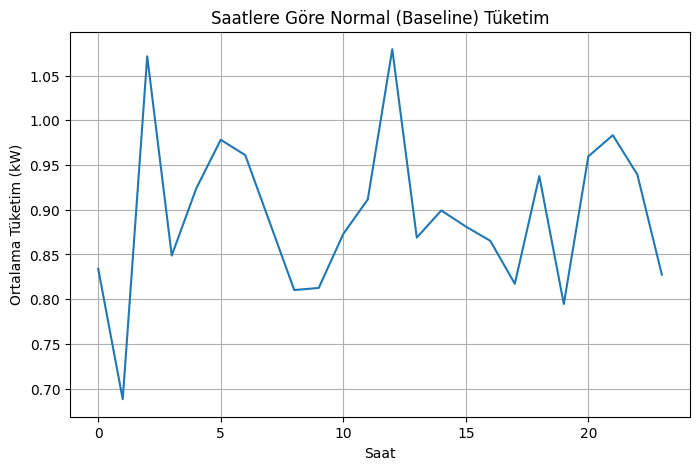

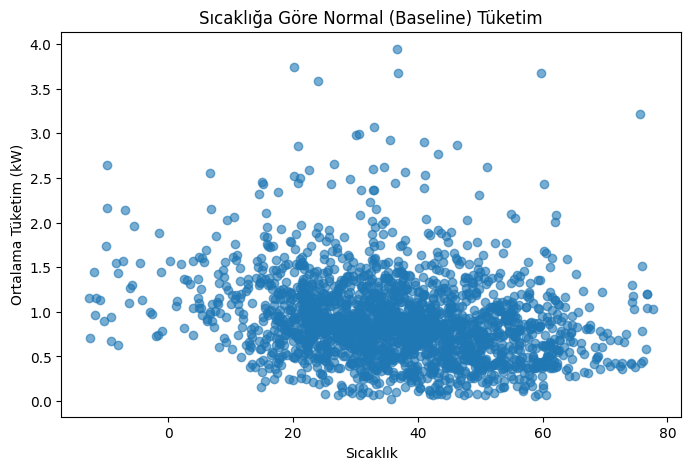

In [14]:
hour_baseline = data.pivot_table(
    index="hour_of_day",
    values="use [kW]",
    aggfunc="mean"
).rename(columns={"use [kW]": "hour_baseline_kw"})

temp_baseline = data.pivot_table(
    index="temperature",
    values="use [kW]",
    aggfunc="mean"
).rename(columns={"use [kW]": "temp_baseline_kw"})

humid_baseline = data.pivot_table(
    index="humidity",
    values="use [kW]",
    aggfunc="mean"
).rename(columns={"use [kW]": "humidity_baseline_kw"})

wind_baseline = data.pivot_table(
    index="windSpeed",
    values="use [kW]",
    aggfunc="mean"
).rename(columns={"use [kW]": "wind_baseline_kw"})

print("\n=== BASELINE PIVOT TABLOLARI ===")

print("\nSaat Bazlı Normal Tüketim (hour_baseline):")
print(hour_baseline)

print("\nSıcaklığa Göre Normal Tüketim (temp_baseline):")
print(temp_baseline.head(10))

print("\nNeme Göre Normal Tüketim (humidity_baseline):")
print(humid_baseline.head(10))

print("\nRüzgar Hızına Göre Normal Tüketim (wind_baseline):")
print(wind_baseline.head(10))
plt.figure(figsize=(8,5))
plt.plot(hour_baseline.index, hour_baseline["hour_baseline_kw"])
plt.xlabel("Saat")
plt.ylabel("Ortalama Tüketim (kW)")
plt.title("Saatlere Göre Normal (Baseline) Tüketim")
plt.grid()
plt.show()
plt.figure(figsize=(8,5))
plt.scatter(
    temp_baseline.index,
    temp_baseline["temp_baseline_kw"],
    alpha=0.6
)
plt.xlabel("Sıcaklık")
plt.ylabel("Ortalama Tüketim (kW)")
plt.title("Sıcaklığa Göre Normal (Baseline) Tüketim")
plt.show()


In [7]:
data = data.merge(hour_baseline, on="hour_of_day", how="left")
data = data.merge(temp_baseline, on="temperature", how="left")
data = data.merge(humid_baseline, on="humidity", how="left")
data = data.merge(wind_baseline, on="windSpeed", how="left")


In [8]:
threshold = data["use [kW]"].mean()
target = (data["use [kW]"] > threshold).astype(int)

In [9]:
feature_cols = [
    "hour_of_day", "weather_label",
    "temperature", "humidity", "visibility", "windSpeed",
    "pressure", "cloudCover", "windBearing",
    "dewPoint", "precipProbability",
    "hour_baseline_kw", "temp_baseline_kw",
    "humidity_baseline_kw", "wind_baseline_kw"
]

X = data[feature_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.2, random_state=42
)

In [11]:
classifiers = {
    "Logistic Model": LogisticRegression(max_iter=7000),
    "Random Forest Model": RandomForestClassifier(
        n_estimators=100, random_state=42
    )
}


In [12]:
for model_name, clf in classifiers.items():
    print(f"\n{model_name} çalıştırılıyor...")
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: %{acc*100:.2f}")
    print(classification_report(y_test, preds))



Logistic Model çalıştırılıyor...
Accuracy: %74.92
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     19326
           1       0.73      0.60      0.66     12921

    accuracy                           0.75     32247
   macro avg       0.74      0.72      0.73     32247
weighted avg       0.75      0.75      0.74     32247


Random Forest Model çalıştırılıyor...
Accuracy: %78.57
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     19326
           1       0.75      0.70      0.72     12921

    accuracy                           0.79     32247
   macro avg       0.78      0.77      0.77     32247
weighted avg       0.78      0.79      0.78     32247



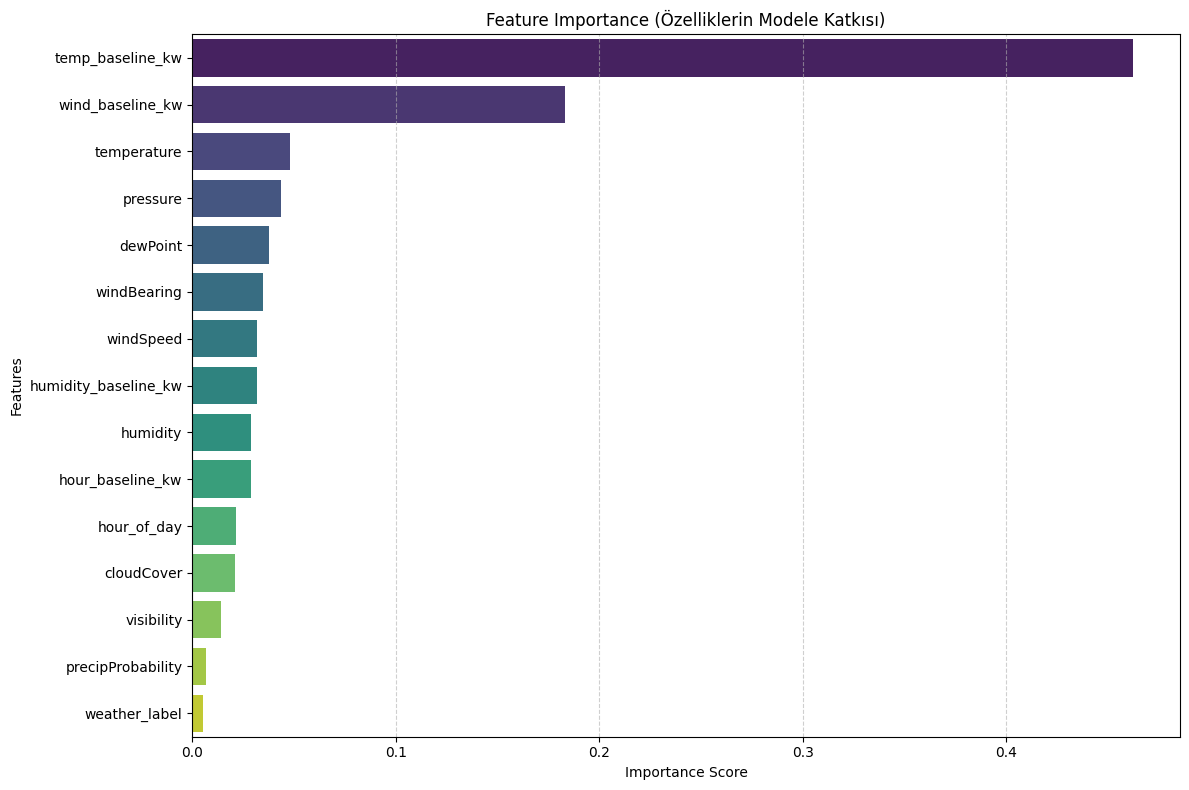

In [13]:
rf_clf = classifiers["Random Forest Model"]

importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    hue="Feature",
    legend=False,
    palette="viridis"
)

plt.title("Feature Importance (Özelliklerin Modele Katkısı)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()